In [1]:
'''
Centroid based Tabu Search Algorithm
'''

# Needed when running in a standalone environment
# import findspark
# findspark.init()
import math
import pandas as pd
import numpy as np

import pyspark

from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA
import pprint

from random import seed
from random import randint
seed(1)

# 0. DATA WRANGLING

In [2]:
'''
Importing data
Removing unwanted fields
Filling nulls
Aggregating some fields to get new fields
Selecting wanted rows
Building different datasets
'''

'''Function to calculate new data based on previous columns'''
'''
def flight_status(row):
    if(row.Cancelled == 1):
        return 1
    if(row.Diverted == 1):
        return 2
    return 3
    

# Reading dataset from CSV
# df = (spark.read
#     .option("header", "true")
#     .option("mode", "DROPMALFORMED")
#     .csv("airlinedelaycauses/DelayedFlights.csv"))


# # import some data to play with
# iris = datasets.load_iris()
# df = pd.DataFrame(iris.data)
# show_graphs(iris)


df = pd.read_csv("airlinedelaycauses/DelayedFlights.csv") 
# df.dropna(inplace=True)

# Calculating new column
df['flight_status'] = df.apply (lambda row: flight_status(row), axis=1)

# Dropping columns not needed
df.drop(columns=['Unnamed: 0', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'CancellationCode', 'Cancelled', 'Diverted'], inplace=True)

# Recalculating Dataframe
cancelled = df[df.flight_status == 1]
diverted = df[df.flight_status == 2]
ok = df[df.flight_status == 3].head(1613)
centroids
# Merging dataframe
df = pd.concat([ok, cancelled, diverted])
df.fillna(0, inplace=True)
    

# Saving Pickle
df.to_pickle('./flight_status10000.pkl')

# Equalizing the data
diverted = df[df.flight_status == 2].head(633)
ok = df[df.flight_status == 3].head(634)

df = pd.concat([cancelled, diverted, ok])

df.fillna(0, inplace=True)

# Saving Another Pickle
df.to_pickle('./flight_status1900_equalized.pkl')
'''

# Getting saved model from pickle
# df = pd.read_pickle('./flight_status10000.pkl')
df = pd.read_pickle('./flight_status1900_equalized.pkl')

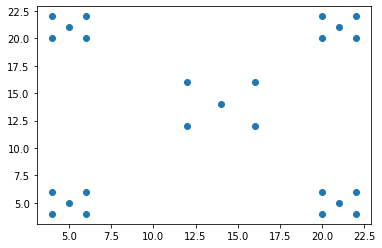

In [2]:
# Research dataset
dataset = np.array([[4,4], [6, 6], [4,6], [6,4], [5, 5], 
          [20,4], [22, 6], [20,6], [22,4], [21, 5],
          [4,20], [6, 22], [4,22], [6,20], [5, 21],
          [20,20], [22, 22], [20,22], [22,20], [21, 21],
          [16,12], [12, 16], [16,16], [12,12], [14, 14],])


plt.scatter(dataset[:,0], dataset[:,1])
plt.show()

## 0.1 Utility Functions

In [3]:
def pop_dataframe_row(df, index):
    item = df.iloc[[index]]
    df.drop(df.index[index], inplace=True)
    df.reset_index(drop=True)
    return item


def show_graphs(x, y):
    X = x[:, 5:7]  # we only take the first two features.

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    plt.figure(2, figsize=(8, 6))
    plt.clf()

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
                edgecolor='k')
    plt.xlabel('Departure Time')
    plt.ylabel('Arrival Time')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    X_reduced = PCA(n_components=3).fit_transform(x)
    #(df2{2 0 1 - 0 2 1}) (df{1 2 0 - 2 0 1})
    ax.scatter(X_reduced[:, 2], X_reduced[:, 0], X_reduced[:, 1], c=y, 
               cmap=plt.cm.Set1, edgecolor='k', s=50)
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

# 1. EXPLORATORY DATA ANALYSIS

## 1.1 Principal Component Analysis

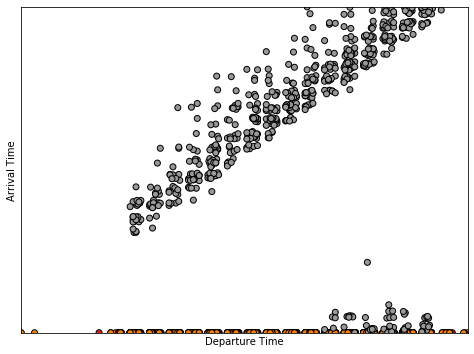

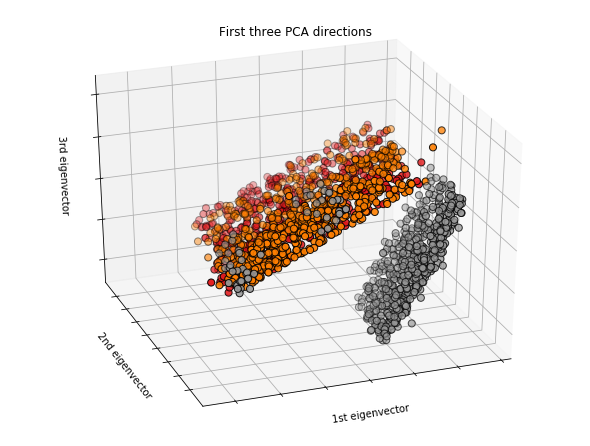

In [5]:
# df1 = df.sample(1000)
df1 = df

x = df1.drop(['flight_status'], axis=1).values
y = df1.flight_status.values

show_graphs(x, y)

## 1.2 Correlation Matrix

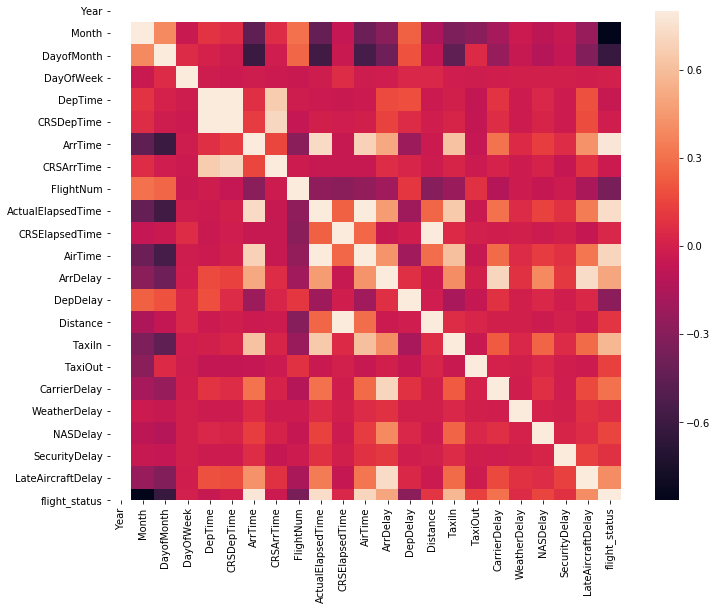

In [43]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

# 2. Tabu Search Based Clustering

In [4]:
# our euclidean function
#𝑆𝑐𝑜𝑟𝑒(𝑥𝑖, 𝑥𝑗)
def distance_from_centroid(centroid, points):
    return np.hypot(*(points - centroid).T)

In [5]:
# the total distance (from all data points to the centroid) of cluster Ci
# 𝑉(𝑖) = ∑ 𝑆𝑐𝑜𝑟𝑒(𝑥𝑗, 𝑜𝑖), 𝑥𝑗 ∈ 𝐶𝑖, 𝑎𝑛𝑑 𝑥𝑗 ≠ 𝑜𝑖
def sum_of_distance_from_centroid_to_all_points(centroid, points):
    return distance_from_centroid(centroid,points).sum()

In [6]:
#The objective function of our clustering problem that we seek to minimize
# 𝑜𝑏𝑗𝑉𝑎𝑙 = ∑𝑖=𝑁𝑠 𝑖=1 𝑉(𝑖)
def objective_function(centroids, dataset):
    sumarray = []
    for i in range(len(centroids)):
        y = dataset[dataset["Centroid"] == i]
        y.drop(["Centroid"], axis = 1, inplace=True)
        onesum = sum_of_distance_from_centroid_to_all_points(centroids[i], y.values)
        sumarray.append(onesum)
    return sum(sumarray)

In [7]:
# Ri
def get_radii(Ci, centroids):
    radii = []
    for idx in range(len(centroids)):
        y = Ci[Ci["Centroid"] == idx]
        y.drop(["Centroid"], axis = 1, inplace=True)
        radii.append(math.ceil(sum_of_distance_from_centroid_to_all_points(centroids[idx], y.to_numpy()) / len(y)))
    return radii

In [8]:
# Ni
def neighborhood_determination(Ci, centroids):
    Ri = get_radii(Ci, centroids)
    neighborhoods = []
    for idx in range(len(centroids)):
        y = Ci[Ci["Centroid"] == idx]
        y.drop(["Centroid"], axis = 1, inplace=True)
        y = y.to_numpy()
        neighborhoods.append([i for i in y if distance_from_centroid(centroids[idx], i) <= Ri[idx]])
        
    return neighborhoods

In [9]:
'''
Construct Initial Solution

We assume the number of clusters, Ns, is greater than 1

Input Parameters:
Ci       -> the ith Cluster(dataset)
Ns       -> the number of clusters to make
'''


def initial_solution(Ci, Ns):
    
    '''    
    a. Randomly select a data point as the first centroid.
    b. Calculate the distance of the remaining data points to the existing centroids, and choose
    the data point with the largest sum of these distances as the new centroid.
    c. Repeat step b until Ns centroids are selected.
    d. Assign each remaining data pointto its closest centroid to determine the resulting clusters.
    '''
    idx = randint(0, len(Ci)-1)
    centroids = []
    for i in range(Ns):
        # need to pop so we dont select same centroid over again
        item = pop_dataframe_row(Ci, idx).values[0]
        centroids.append(item)
        euc_dist = list(distance_from_centroid(item, Ci.values))
        idx = euc_dist.index(max(euc_dist))
    
    centroid_to_assign = []
    dists = []
    
    for i in range(len(Ci)):
        for j in range(Ns):
            dist = distance_from_centroid(centroids[j], Ci.iloc[[i]].values[0])
            dists.append(dist)
         
        idxs = [i for i, x in enumerate(dists) if x == min(dists)]
        if(len(idxs) > 1):
            if(centroid_to_assign.count(idxs[0]) > centroid_to_assign.count(idxs[1])):
                centroid_to_assign.append(idxs[1])
            else:
                centroid_to_assign.append(idxs[0])
        else: 
            centroid_to_assign.append(idxs[0])
                
        dists = []
            
    Ci = pd.concat([Ci, pd.DataFrame(centroids)])
    
    for i in range(Ns):
        centroid_to_assign.append(i)
    
    Ci["Centroid"] = centroid_to_assign

    return centroids, Ci

In [ ]:
'''
Cadidate List Creation for single cluster

Input Parameters:
Ci       -> the ith Cluster(dataset)
Ni       -> neighborhood for Cluster i
Ri       -> radius for Cluster Ci
Vk       -> sum of distances(scores) for data point xk
V_k      -> value of Vk obtained at the most recent local optimum
ni       -> number of datapoints to be included in the Candidate list for Ci
epsilon  -> the number of data points whose current Vk values are less than V_k
delta    -> an integer drawn randomly from the interval [0,|Ni|-epsilon]
'''

def create_candidate_list(Ci, Centroids, Vk, V_k, ni, epsilon, delta):
    Ni = neighborhood_determination(Ci, Centroids)
    
    for idx in range(len(Centroids)):
        

        

#     //creating component neighborhood
#     1 For all clusters 𝐶1, 𝐶2, … , 𝐶𝑠
#     Create 𝑁(𝑖) using radius 𝑅𝑖
#     //computing total distance (sum of scores)
#     2 For all clusters 𝐶1, 𝐶2, … , 𝐶𝑠
#     3 𝑖 = the current cluster index
#     4 𝑥𝑖 = the centroid of cluster 𝐶𝑖
#     5 For each point 𝑥𝑘 ∈ 𝑁(𝑖) other than 𝑥𝑖
#     6 𝐿 = {𝑥𝑖}, 𝑈 = 𝑁(𝑖)\{𝑥𝑖, 𝑥𝑘}
#     7 Computing 𝑉(𝑘) using (2.4)
#     //creating candidate list
#     8 Sort the data points 𝑥𝑘 ∈ 𝑁(𝑖) (𝑖 = 1, … , 𝑁𝑠) in ascending order of their 𝑉(𝑘) values
#     9 For all clusters 𝐶1, 𝐶2, … , 𝐶𝑠
#     10 𝑛(𝑖) = 𝜀 + 𝜆
#     11 𝐶𝐿(𝑖) = first 𝑛(𝑖) data points in the sorted 𝑁(𝑖) list
#     12 𝐶𝐿 = ⋃ 𝐶𝐿(𝑖)
#     𝑁𝑠
#     1
#     13 return 𝐶𝐿(𝑖), 𝑖 = 1, … , 𝑁s

In [10]:
def tabu_search_clustering(Ci, Ns, maxNonImprIter, nIter):
    centroids, sol = initial_solution(Ci, Ns)
    optSol = sol
    bestObjVal = objective_function(centroids, sol)
    optObjVal = bestObjVal
    objVal = bestObjVal

    nonImprovIter = 0
    currentIter = 0

#     while((nonImprovIter < maxNonImprIter) & (currentIter < nIter)):
#         Create candidate lists for all clusters sorted in ascending order(array of arrays)

    